In [ ]:
from datasets import load_dataset
import pandas as pd
import os

base_path = "/content/drive/MyDrive/nlp_7th_sem/lab3"

train_file = f"{base_path}/train.csv"
validation_file = f"{base_path}/test.csv"

if not (os.path.exists(train_file) and os.path.exists(validation_file)):
    raise RuntimeError(f"Error: Dataset files not found. Please ensure {train_file} and {validation_file} are in the current directory.")

raw_datasets = load_dataset(
        "csv",
        data_files={
            "train": train_file,
            "validation": validation_file
        }
    )
print("Successfully loaded datasets:")
print(raw_datasets)


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Successfully loaded datasets:
DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'source'],
        num_rows: 8500
    })
    validation: Dataset({
        features: ['title', 'text', 'source'],
        num_rows: 2000
    })
})


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_CHECKPOINT = "youscan/ukr-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

num_labels = raw_datasets["train"].to_pandas()['source'].max() + 1

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=num_labels
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/507M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at youscan/ukr-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(examples):
    full_text = [t + " " + x for t, x in zip(examples["title"], examples["text"])]

    return tokenizer(
        full_text,
        truncation=True,
        padding=True
    )

raw_datasets = raw_datasets.rename_column("source", "labels")
tokenized_datasets = raw_datasets.map(tokenize, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(['title', 'text'])
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]

Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
    }

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=f'{base_path}/results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='f1_score',
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Starting fine-tuning...")
trainer.train()

print("\n--- Final Validation Metrics ---")
final_results = trainer.evaluate(val_dataset)
print(final_results)

/tmp/ipython-input-1401926237.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.428300,0.435853,0.859500,0.875314,0.859500,0.861409
2,0.281800,0.362574,0.910500,0.911539,0.910500,0.910116
3,0.080400,0.376051,0.922000,0.922265,0.922000,0.922006



--- Final Validation Metrics ---


{'eval_loss': 0.37605124711990356, 'eval_accuracy': 0.922, 'eval_precision': 0.9222649126838949, 'eval_recall': 0.922, 'eval_f1_score': 0.9220060836842313, 'eval_runtime': 62.2467, 'eval_samples_per_second': 32.13, 'eval_steps_per_second': 4.016, 'epoch': 3.0}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions_output = trainer.predict(val_dataset)

logits = predictions_output.predictions
true_labels = predictions_output.label_ids

predicted_labels = np.argmax(logits, axis=-1)

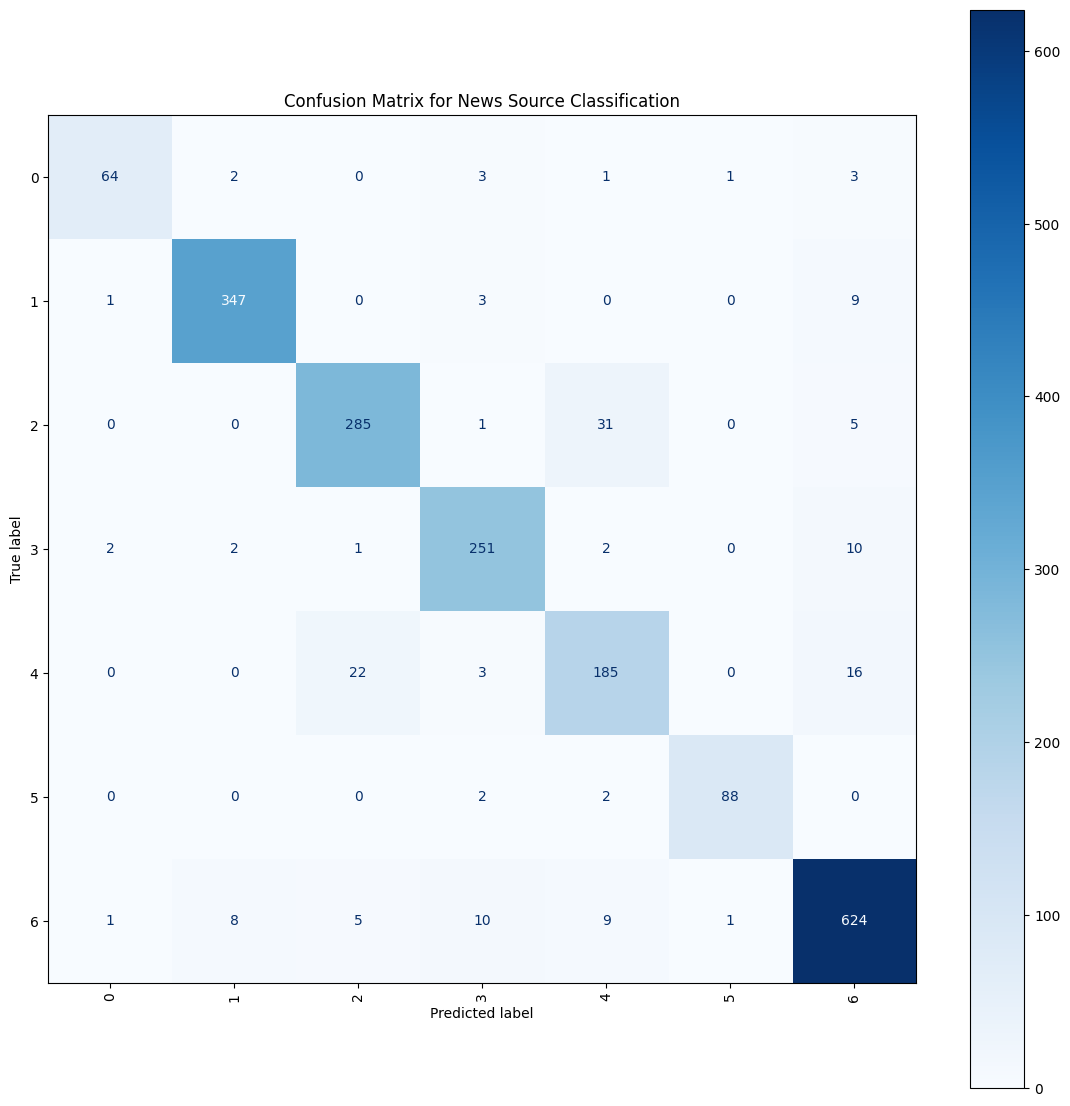

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_labels))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm
)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
ax.set_title("Confusion Matrix for News Source Classification")
plt.show()